# Atividade 5 - Séries Sintéticas


### Eduardo Mendes Loureiro



## Imports

#### Instalar as bibliotecas

Descomentar e rodar caso necessário

In [1]:
## PySDDP

# !pip install PySDDP=='0.0.34'


## Faz o link com a sua conta do Google Drive

# from google.colab import drive
# drive.mount('/content/drive')

#### Realizar os imports necessários

*   Classe Newave do PySDDP: Realiza a leitura do deck do modelo Newave e encapsula todas as informações em um único objeto
*   Importa a biblioteca Numpy com o "apelido" np
* Importa as classes gráficas matplotlib e plotly

In [2]:
from PySDDP.Pen import Newave
import numpy as np
import pandas as pd
from cvxopt import solvers, matrix
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from numpy.random import randint


## Leitura do deck do PMO



Realiza a leitura de um deck do pmo;

Adaptar a variável caminho conforme a pasta em que o deck estiver.

In [3]:
# Caminho = '/content/drive/MyDrive/NewaveJan2021'

Caminho = './NW202308_UNSI_ACL'

Caso = Newave(Caminho)

OK! Leitura do CASO.DAT realizada com sucesso.
OK! Leitura do ARQUIVOS.DAT realizada com sucesso.
OK! Leitura do DGER.DAT realizada com sucesso.
OK! Leitura do HIDR.DAT realizada com sucesso.
OK! Leitura do VAZOES.DAT realizada com sucesso.
OK! Leitura do MODIF.DAT realizada com sucesso. ( 99 Usinas Hidraulicas Modificadas )
OK! Leitura do EXPH.DAT realizada com sucesso. ( 2 Usinas Hidraulicas Expandidas )
OK! Leitura do CONFHD.DAT realizada com sucesso.
OK! Leitura do REE.DAT realizada com sucesso. ( 12 Reservatórios Equivalentes de Energia Foram Lidos )
OK! Leitura do SISTEMA.DAT realizada com sucesso.


## Modelo de Otimização para o Problema Analisado



Para o caso exemplo do mês de agosto a ser estimado a vazão


$\hspace{1cm}$


$\hspace{1cm} Min \hspace{0.5cm} \varepsilon_{ago,1931}^2 + \varepsilon_{ago,1932}^2  + ... + \varepsilon_{ago,2020}^2  + \varepsilon_{ago,2021}^2  $


Sujeito a:


$Z_{ago,1932} = \phi_1 \cdot Z_{jul,1932} + \phi_2 \cdot Z_{jun,1932} + ... +  \phi_n \cdot Z_{n,1932}  + \varepsilon_{ago,1932}^2  $

$Z_{ago,1933} = \phi_1 \cdot Z_{jul,1933} + \phi_2 \cdot Z_{jun,1933} + ... +  \phi_n \cdot Z_{n,1933}  + \varepsilon_{ago,1933}^2  $

...

$Z_{ago,2021} = \phi_1 \cdot Z_{jul,2021} + \phi_2 \cdot Z_{jun,2021} + ... +  \phi_n \cdot Z_{n,2021}  + \varepsilon_{ago,2021}^2  $


$\hspace{1cm}$

## Função de Otimização do Modelo Auto-Regressivo

Função para otimização dos coeficientes $\phi_n$ de uma usina, dados a ordem e o mês.

Problema quadrático, solucionado matricialmente.
Foram utilizadas funções auxiliares para criação das matrizes.

In [4]:
def otimizar_phi(usina, ordem, mes):


    # esta funcao recebe os meses de 1 a 12; portanto, 
    # inicialmente deve-se trazer janeiro para 0
    mes = mes-1  


    # vazões naturais afluentes - ignorar o último ano 
    vazoes = usina['vazoes'][0:-2]


    # Criar parâmetros do problma quadrático por meio de funções auxiliares
    P = matrix(criar_matriz_P(vazoes, ordem, mes))*1.0
    q = matrix(criar_vetor_q(vazoes, ordem, mes))*1.0
    G = None
    h = None
    A = matrix(criar_matriz_A(vazoes, ordem, mes))*1.0
    b = matrix(criar_vetor_b(vazoes, ordem, mes))*1.0


    # Definir tolerâncias de convergência
    abstol = 1e-8
    reltol = 1e-8
    

    # Solucionar problema quadrático
    sol = solvers.qp(P, q, G, h, A, b, solver='glpk', abstol=abstol, reltol=reltol)

    resultado = {
        "phi": np.array(sol['x'][:ordem]),
        "erros": np.array(sol['x'][ordem:]),
        "fob": np.array(sol['primal objective'])
    }

    return resultado



## -------------------------------------------------------------------------- ##
## -------------------------  Funções auxiliares ---------------------------- ##
## -------------------------------------------------------------------------- ##



def criar_matriz_P(vazoes, ordem, mes):
    # matriz quadrática da fob

    num_ano, num_mes = np.shape(vazoes)

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_ano -= 1

    # criar matriz
    matriz = np.diag(np.concatenate((np.zeros(ordem), 2*np.ones(num_ano)), axis=0))
    return matriz


def criar_vetor_q(vazoes, ordem, mes):
    # vetor de termos lineares da fob
    
    num_ano, num_mes = np.shape(vazoes)

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_ano -= 1

    # criar vetor
    vetor = np.zeros(ordem + num_ano)
    return vetor


def criar_matriz_A(vazoes, ordem, mes):
    # matriz de coeficientes das restrições de igualdade
    
    # transformar matriz de vazões em um vetor
    vetor_aux = vazoes.flatten()
    
    # dividir vetor:
    # - primeiro valor é referente ao mês de interesse 
    # - último valor é referente ao mês anterior
    linha_1, flat_matrix, linha_final = np.split(vetor_aux, [mes, mes-12])

    # incorporar dados da primeira linha caso o mês seja maior ou igual à ordem
    if (mes >= ordem):
        # primeira linha - zeros à esquerda (total de itens = 12)
        linha_1 = np.concatenate((np.zeros(12-mes), linha_1))

        # incluir primeira linha na matriz
        flat_matrix = np.concatenate((linha_1, flat_matrix), axis=0)

    # definir dimensoes da matriz reconfigurada 
    num_mes = 12
    num_anos = np.size(flat_matrix)//num_mes

    # criar matriz com os meses necessários 
    matriz = np.reshape(flat_matrix, (num_anos, num_mes))[:,-ordem:]

    # concatenar erros de cada equação (matriz identidade)
    matriz = np.concatenate((matriz, np.eye(num_anos)), axis=1)
    return matriz


def criar_vetor_b(vazoes, ordem, mes):
    # vetor de termos independentes das restrições de igualdade
    
    num_linha_1 = 0

    # ignonar dados do primeiro ano do histórico caso o mês seja menor que a ordem
    if (mes < ordem):
        num_linha_1 += 1

    # criar vetor
    vetor = vazoes[num_linha_1:, mes]
    return vetor

## **Programa Principal**

#### *Dados de entrada*


In [5]:
# nome da usina escolhida
nome_usina = 'Itaipu' # Furnas, Itaipu, Belo Monte, Sobradinho, Tucurui

# obter dados da usina
usina = Caso.confhd.get(nome_usina)

# ordem do modelo auto-regressivo
ordem = 11

# mês analisado
mes = 1

#### *Otimizar coeficientes para todas as ordens*

In [6]:
ordem_max = 11
resultado = {}
FOB = np.zeros((ordem_max,12))

for i_ord in np.arange(1,ordem_max+1,1):  # ordens de 1 a 11
    phi = []
    erros = []

    for i_mes in np.arange(1,12+1,1):  # meses de 1 a 12
        otimizacao = otimizar_phi(usina, i_ord, i_mes)
        
        phi.append(otimizacao['phi'])
        erros.append(otimizacao['erros'])
        FOB[i_ord-1, i_mes-1] = otimizacao['fob']

    resultado['ordem_' + str(i_ord)] = {'phi': phi, 'erros': erros}

#### *Exibir coeficientes p/ mês e ordem escolhidos*

In [7]:
mes_lista = ['Janeiro','Fevereiro','Março','Abril','Maio','Junho','Julho','Agosto','Setembro','Outubro','Novembro','Dezembro']
meses_coef = list()
for ord in range(mes - ordem - 1,mes-1):
    if ord<0:
        mes_ano_anterior = 13 + ord
        meses_coef.append(mes_lista[mes_ano_anterior-1])
    else:
        meses_coef.append(mes_lista[ord])


print("\n\nCoeficientes para a ordem " + str(ordem) + ", mês de " + str(mes_lista[mes-1]) + ":")

pd.DataFrame(data = [resultado['ordem_' + str(ordem)]['phi'][mes-1].T][0], columns=meses_coef, index=['Coeficientes'])




Coeficientes para a ordem 11, mês de Janeiro:


,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
Coeficientes,-0.154602,0.253721,0.053301,0.270928,-0.437282,0.263872,0.417021,-0.169841,-0.147409,0.085981,0.97826


#### *Encontrar melhor ordem para cada mês*

In [8]:
# Find the minimum value for each column
min_values = np.amin(FOB, axis=0)

# Find the indices of the minimum values in each column
min_indices = np.argmin(FOB, axis=0)
melhor_ordem = min_indices+1

# Exibir Dataframe com os valores mínimos e as melhores ordens para cada mês
pd.DataFrame(data = [min_values, melhor_ordem], columns=mes_lista, index=['FOB min','Melhor ordem']).applymap(lambda x: '{:,.0f}'.format(x))


,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
FOB min,"877,322,447","1,030,756,941","752,382,096","245,012,750","343,986,108","398,234,897","182,205,786","138,725,490","208,146,099","376,744,545","261,577,418","437,145,933"
Melhor ordem,11,11,11,11,11,11,11,11,11,11,11,11


#### *Guardar coeficientes*

Caso a melhor ordem em algum mês seja menor do que a ordem máxima, as colunas sobressalentes serão preenchidas por zeros.

In [9]:
coeficientes = np.zeros((12,ordem_max))

for i, imes in enumerate(mes_lista):
    for j in range(melhor_ordem[i]):
        coeficientes[i][j] = resultado['ordem_' + str(melhor_ordem[i])]['phi'][i][j][0]

pd.DataFrame(data = [coeficientes][0], columns=[f"phi_{i}" for i in range(1, 12)], index=[mes_lista])

,phi_1,phi_2,phi_3,phi_4,phi_5,phi_6,phi_7,phi_8,phi_9,phi_10,phi_11
Janeiro,-0.154602,0.253721,0.053301,0.270928,-0.437282,0.263872,0.417021,-0.169841,-0.147409,0.085981,0.978260
Fevereiro,0.139589,-0.002115,0.320907,-0.348563,0.104507,0.632534,-0.312486,-0.374476,0.215571,0.410380,0.495654
Março,0.260741,0.192725,-0.340690,0.499271,-0.069571,-0.505906,-0.000938,0.223701,0.224578,-0.104116,0.621371
Abril,-0.178491,0.232340,-0.132238,0.454029,-0.021919,0.092347,-0.009021,0.096350,-0.123006,0.109171,0.541567
Maio,-0.085846,0.215987,0.459281,-0.209017,-0.021958,-0.050435,0.215013,-0.115782,0.122503,0.028883,0.388241
Junho,0.358306,0.006968,-0.334863,-0.021307,0.014187,0.134954,0.029881,0.016628,-0.153241,0.079580,0.791998
Julho,0.213291,-0.091115,-0.004435,-0.132643,0.075112,0.002875,0.037124,-0.003649,0.242289,-0.098002,0.510042
Agosto,0.091090,-0.109602,0.062066,-0.031479,0.085346,-0.060940,0.020185,0.105045,0.198410,-0.040895,0.400163
Setembro,0.097921,0.066510,-0.096151,-0.021609,0.036078,-0.021781,-0.048703,0.011005,-0.086093,0.150329,0.994292
Outubro,-0.053659,0.084528,-0.077954,0.106461,-0.088557,0.309002,-0.120913,0.047725,0.048957,0.139320,0.587951


#### *Guardar lista de meses usados no calculo p/ cada mês*

In [10]:
lista_meses_coef = {}

for m, mes in enumerate(mes_lista):
    meses_coef = list()
    for ord in range(m - melhor_ordem[m],m):
        if ord<0:
            mes_ano_anterior = 13 + ord
            meses_coef.append(mes_lista[mes_ano_anterior-1])
        else:
            meses_coef.append(mes_lista[ord])
    
    lista_meses_coef[mes] = meses_coef

#### *Guardar erros*

In [11]:
erros_mes = {}

for i, imes in enumerate(mes_lista):
    x = resultado['ordem_' + str(melhor_ordem[i])]['erros'][i].reshape(1,-1)[0]
    erros_mes[imes] = x.tolist()



### *Séries sintéticas*

#### *Função para sortear erros*

Garante que a média dos erros seja próxima de zero

In [12]:

def sortear_erros(erros_mes, lista_meses_nestagios, mes_lista, mes_inicial, nestagios):

    
    # Número de seleções aleatórias de cada mês em cada iteração
    contagem_selecoes_por_mes = []
    for mes in mes_lista:
        contagem_selecoes_por_mes.append(lista_meses_nestagios.count(mes))

    # Tolerancia para a media dos erros
    tol = 1e-1
    selecao = [1]
    max_tentativas = 1e7
    tentativa = 0

    # garantir que a média dos erros seja próxima de zero
    while abs(np.mean(selecao)) > tol:

        tentativa += 1
        if tentativa > max_tentativas:
            print('Não foi possível encontrar uma seleção satisfatória. Número máximo de tentativas atingido.')
            break

        selecao = []
        for it, dados_mes in enumerate(erros_mes.values()):
            selecao.extend(np.random.choice(dados_mes, size=contagem_selecoes_por_mes[it], replace=False))

    return selecao


#### *Criar séries*

In [17]:
num_series = 2000

ano_inicial = 2023
mes_inicial = 9 # setembro
ano_final = 2027
mes_final = 12 # dezembro

horizonte = (ano_final - ano_inicial + 1)*12 
nestagios = (ano_final - ano_inicial)*12 + mes_final - mes_inicial + 1


# criar lista com os nomes de todos os meses desde o inicial até o fim dos nestagios
lista_meses_nestagios = []
for mes in range(mes_inicial,13):
    lista_meses_nestagios.append(mes_lista[mes-1])

for ano in range(ano_inicial+1, ano_final+1):
    for mes in range(1,13):
        lista_meses_nestagios.append(mes_lista[mes-1])

# inicializar series
series = np.zeros((num_series, horizonte))

for i in range(num_series):

    # fazer uma lista com todas as vazões, e remover os zeros à direita
    serie_i = np.trim_zeros(usina['vazoes'].flatten(), 'b').tolist()[-ordem_max-1:]

    erro_aleat = sortear_erros(erros_mes, lista_meses_nestagios, mes_lista, mes_inicial, nestagios)
    
    for est in range(nestagios):
        
        mes = (mes_inicial + est-1)%12  # 0 a 11

        vazao = 0
        for ord in range(melhor_ordem[mes]):
            vazao += coeficientes[mes][ord]*serie_i[-ordem_max+ord] 
            mes_ord = lista_meses_coef[mes_lista[mes]][ord]

        serie_i.append(vazao + erro_aleat[est])
    series[i] = serie_i[-horizonte:]



np.shape(series)

(2000, 60)

### **Gráficos**

#### *Vazões Reais*

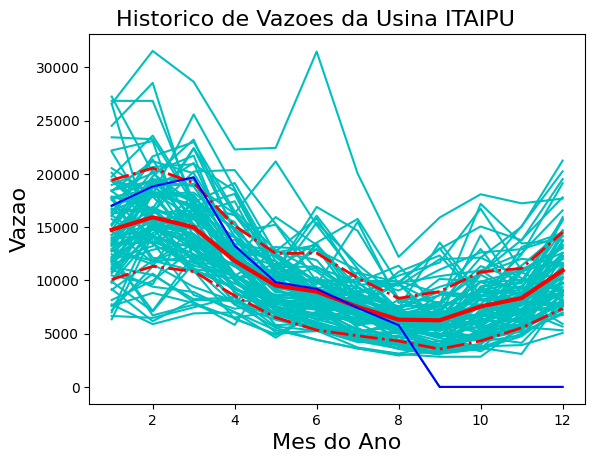

In [37]:
Caso.confhd.plot_vaz(usina)

#### *Vazões Sintéticas*

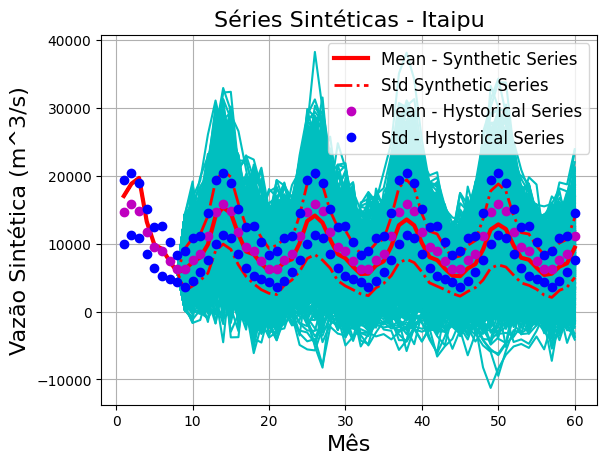

In [38]:
vazoes = usina['vazoes']

nanos = len(vazoes)

media = np.mean(vazoes[1:(nanos-1)], 0)  
desvio = np.std(vazoes[1:(nanos-1)], 0) 

x_axis = np.arange(1, horizonte+1)
plt.plot(x_axis, series.transpose(), 'c-')
plt.plot(x_axis, np.mean(series,0), 'r-', lw=3, label='Mean - Synthetic Series')
plt.plot(x_axis, np.mean(series,0) + np.nanstd(series, axis=0), 'r-.', lw=2, label='Std Synthetic Series')
plt.plot(x_axis, np.mean(series,0) - np.nanstd(series, axis=0), 'r-.', lw=2)
m = np.concatenate([ media, media, media, media, media])
d = np.concatenate([ desvio, desvio, desvio, desvio, desvio])
plt.plot(x_axis, m, 'mo', lw=3, label='Mean - Hystorical Series')
plt.plot(x_axis, m + d, 'bo', lw=2, label='Std - Hystorical Series')
plt.plot(x_axis, m - d, 'bo', lw=2)
titulo = "Séries Sintéticas - " + nome_usina
plt.title(titulo, fontsize=16)
plt.xlabel('Mês', fontsize=16)
plt.ylabel('Vazão Sintética (m^3/s)', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()